# **Description Globale du Code – Problème du Voyageur de Commerce (TSP)**

Ce Notebook montre l'implèmentation d'une solution efficace pour le Problème du Voyageur de Commerce (TSP - Travelling Salesman Problem) en utilisant une approche basée sur la programmation dynamique avec mémoïsation.

L’algorithme utilisé ici repose sur l’approche Held-Karp, une version dynamique du TSP, qui a une complexité de O(($n^2$)*($2^n$))
, bien plus optimale que la recherche exhaustive O(n!) pour un nombre modéré de villes.

# **✅ Structure générale**

* <u>**Classe TravellingSalesmanProblem** </u>: encapsule toute la logique du TSP.

* <u>**Matrice de distances**</u> : représente les distances entre chaque paire de villes.

* <u>**Mémorisation (memo)**</u>: tableau 2D qui stocke les sous-solutions.

* <u>**Backtracking intelligent**</u> : pour reconstruire le chemin optimal après le calcul du coût minimum.

* <u>**Encodage binaire des sous-ensembles**</u>: chaque ensemble de villes visitées est représenté par un entier dont les bits activés indiquent les villes visitées.

## **✅ Installation des bibliothèques utiles pour charger et visualiser des instances TSP**

In [ ]:
!pip install tsplib95
!pip install springpy

## **✅ Importation des bibliothèques nécessaires**

In [ ]:
# imports
import heapq
import time
import numpy as np
from math import ceil
import xml.etree.ElementTree as ET
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time

###  **Partie Initialisation :** __init__(self, distance, start)

➡️ Cette partie initialise les données essentielles pour stocker la mémoire dynamique (bitmasking), la ville de départ, et préparer la reconstruction du chemin optimal.

* la matrice de distances entre les villes .
* la ville de départ .
* le nombre total de villes .
* une structure mémoïsée pour stocker les résultats intermédiaires .
* des variables pour enregistrer le coût minimal et le chemin optimal final.

### **Méthode principale de résolution :** solve(self)


➡️ Le lancement de  l’algorithme :

* Initialisation de la base de la mémorisation.
* Génération des sous-ensembles de villes.
* Pour chaque sous-ensemble et pour chaque ville "prochaine", on déduit la
* meilleure distance à partir d'une ville précédente.
* À la fin, on calcule le coût minimal total et on reconstruit le chemin optimal.

➡️ Principe : Génère tous les sous-ensembles de villes de taille croissante contenant la ville de départ. Pour chaque combinaison et chaque ville de destination, calcule la meilleure transition possible en considérant les sous-ensembles précédents.

### **Calcul du coût total minimal final avec retour à la ville de départ :**  __calculate_min_cost(self)

Objectif : Déterminer le chemin complet minimal en tenant compte du retour obligatoire à la ville d’origine.

➡️ Une fois tous les chemins explorés, cette méthode calcule le coût total minimal du cycle complet (retour à la ville de départ) et mémorise la dernière ville visitée.

### **Reconstruction du plus court chemin optimal :**  __find_shortest_path(self)

➡️ Cette partie reconstruit le chemin optimal depuis la ville de départ jusqu’à la dernière, en parcourant les valeurs mémorisées dans memo de manière intelligente **(backtracking)**, puis revient à la ville initiale.

### **Initialisation de la mémoire dynamique pour les chemins de 2 villes :**  __initialize_memo

 ➡️ Initialiser le tableau memo avec les chemins directs de la ville de départ vers toutes les autres, nécessaires comme base de la récursion.

### **Génération des combinaisons de villes à visiter :** __initialize_combination __initiate_combination

➡️ Principe : Génère récursivement toutes les combinaisons de villes de taille donnée sous forme de bitmask. Cette étape est cruciale pour l’exploration exhaustive de l’espace d’états.

### **Vérification d’appartenance à un sous-ensemble :** @staticmethod

➡️ Vérifie si une ville est absente du sous-ensemble encodé, opération fondamentale et rapide en bitmask.

In [ ]:
class TravellingSalesmanProblem:

# --- initialisation ---

    def __init__(self, distance, start):
        self.distance_matrix = distance
        self.start_city = start
        self.total_cities = len(distance)

        # État final où toutes les villes sont visitées (représenté en binaire)
        self.end_state = (1 << self.total_cities) - 1
        # Tableau de mémorisation pour la programmation dynamique
        self.memo = [[None for _col in range(1 << self.total_cities)] for _row in range(self.total_cities)]

        self.shortest_path = []
        self.min_path_cost = float('inf')

#  --- Résolution du problème TSP ---

    def solve(self):

        # Initialisation des cas de base dans le tableau memo
        self.__initialize_memo()

        # On construit les solutions pour des sous-ensembles de plus en plus grands
        for num_element in range(3, self.total_cities + 1):

            # Génère tous les sous-ensembles de num_element villes
            for subset in self.__initiate_combination(num_element):

                # Si la ville de départ ne fait pas partie du sous-ensemble, on ignore
                if self.__is_not_in_subset(self.start_city, subset):
                    continue

                # On essaie de terminer le chemin dans chaque ville possible
                for next_city in range(self.total_cities):

                    if next_city == self.start_city or self.__is_not_in_subset(next_city, subset):
                        continue

                    # Supprime next_city du sous-ensemble courant
                    subset_without_next_city = subset ^ (1 << next_city)
                    min_distance = float('inf')

                    # On regarde toutes les villes précédentes possibles
                    for last_city in range(self.total_cities):

                        if last_city == self.start_city or \
                                last_city == next_city or \
                                self.__is_not_in_subset(last_city, subset):
                            continue

                        # Calcule la distance si on arrive à next_city depuis last_city
                        new_distance = \
                            self.memo[last_city][subset_without_next_city] + self.distance_matrix[last_city][next_city]

                        if new_distance < min_distance:
                            min_distance = new_distance

                    # On enregistre la plus courte distance pour atteindre next_city avec le sous-ensemble courant
                    self.memo[next_city][subset] = min_distance

        self.__calculate_min_cost() # Calcul du coût minimal avec retour à la ville de départ
        self.__find_shortest_path() # Reconstruction du plus court chemin optimal

# --- Calcul du coût total minimal final avec retour à la ville de départ ---

    def __calculate_min_cost(self):
        for i in range(self.total_cities):

            if i == self.start_city:
                continue

            # Coût total = coût pour arriver à i + retour à la ville de départ
            path_cost = self.memo[i][self.end_state] + self.distance_matrix[i][self.start_city]

            if path_cost < self.min_path_cost:
                self.min_path_cost = path_cost

   # --- Reconstruction du plus court chemin ---

    def __find_shortest_path(self):
        state = self.end_state  # État initial : toutes les villes ont été visitées

        for i in range(1, self.total_cities):
            best_index = -1
            best_distance = float('inf')

            # Cherche la ville qui donne la meilleure distance pour l'état courant
            for j in range(self.total_cities):

                if j == self.start_city or self.__is_not_in_subset(j, state):
                    continue

                new_distance = self.memo[j][state]

                if new_distance <= best_distance:
                    best_index = j
                    best_distance = new_distance

            self.shortest_path.append(best_index)  # Ajoute la meilleure ville au chemin
            state = state ^ (1 << best_index)      # Met à jour l'état en enlevant cette ville

        self.shortest_path.append(self.start_city) # Termine le chemin en ajoutant la ville de départ
        self.shortest_path.reverse()               # Inverse le chemin pour qu'il commence à la ville de départ


# --- Initialisation des cas de base ---

    def __initialize_memo(self):
        for destination_city in range(self.total_cities):

            if destination_city == self.start_city:
                continue

            # Pour chaque ville, initialise le coût depuis la ville de départ (ensemble de 2 villes)
            self.memo[destination_city][1 << self.start_city | 1 << destination_city] = \
                self.distance_matrix[self.start_city][destination_city]

# --- Génère les sous-ensembles de villes de taille num_element ---

    def __initiate_combination(self, num_element):
        subset_list = []
        self.__initialize_combination(0, 0, num_element, self.total_cities, subset_list)
        return subset_list

# --- Fonction récursive pour générer les combinaisons (par bitmask) ---

    def __initialize_combination(self, subset, at, num_element, total_cities, subset_list):

        elements_left_to_pick = total_cities - at
        if elements_left_to_pick < num_element:
            return

        if num_element == 0:
            subset_list.append(subset)
        else:
            for i in range(at, total_cities): # Ajoute la ville i à l'ensemble (bit à 1)
                subset |= 1 << i
                self.__initialize_combination(subset, i + 1, num_element - 1, total_cities, subset_list)
                # Retire la ville i pour la prochaine combinaison
                subset &= ~(1 << i)

# --- Vérifie si une ville ne fait pas partie d’un sous-ensemble ---

    @staticmethod
    def __is_not_in_subset(element, subset):
        return ((1 << element) & subset) == 0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving berlin52.xml to berlin52.xml


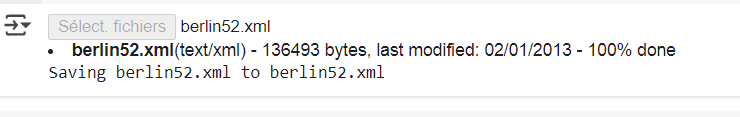

### **Extraction des données depuis un fichier XML et construction de la matrice de distances**

* Lire un fichier XML représentant un graphe pondéré (comme une instance TSP personnalisée)
* Convertir la structure XML en matrice de distances carrée adaptée aux algorithmes de type TSP
* Extraire un sous-ensemble de taille maîtrisée pour tester et évaluer les performances
* Préparer les données dans un format compatible avec la classe TravellingSalesmanProblem

In [ ]:
#------------------------------------------------------------------------
# Charger et parser le fichier XML
instance = ('berlin52.xml')
problem = ET.parse(instance)
#------------------------------------------------------------------------
root = problem.getroot()  # la racine du fichier XML

# Dictionnaire pour stocker les données du graphe
graphe = {}

# Parcourir les sommets du graphe
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    # Parcourir les arêtes du sommet actuel
    for arete in sommet.findall('edge'):
        cible = int(arete.text)  # ID du sommet cible
        cout = float(arete.get('cost'))
        aretes[cible] = cout
    graphe[i] = aretes  # Ajoute les arêtes au sommet correspondant


nombre_sommets = len(graphe)
print(f"Nombre de nœuds : {nombre_sommets}")

# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)  # Convertit en entiers

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = 15#nombre_sommets  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)




Nombre de nœuds : 52
Nombre de nœuds à prendre pour le test : 15
[[   0  666  281  395  291  326  640  426  600  561 1040  655  975 1120
   299]
 [ 666    0  649 1047  945  978   45  956 1134 1132 1638 1258 1440 1515
   957]
 [ 281  649    0  603  508  542  610  308  485  487 1266  891 1247 1399
   504]
 [ 395 1047  603    0  104   69 1026  525  611  533  663  294  711  897
   100]
 [ 291  945  508  104    0   35  923  470  583  513  760  382  769  944
    25]
 [ 326  978  542   69   35    0  957  491  596  523  726  349  744  922
    40]
 [ 640   45  610 1026  923  957    0  918 1095 1095 1627 1245 1440 1521
   935]
 [ 426  956  308  525  470  491  918    0  183  180 1144  812 1234 1414
   452]
 [ 600 1134  485  611  583  596 1095  183    0   83 1165  873 1316 1507
   561]
 [ 561 1132  487  533  513  523 1095  180   83    0 1082  792 1236 1428
   490]
 [1040 1638 1266  663  760  726 1627 1144 1165 1082    0  387  442  619
   762]
 [ 655 1258  891  294  382  349 1245  812  873  792  38

<ipython-input-30-9f32c971ce0e>:27: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


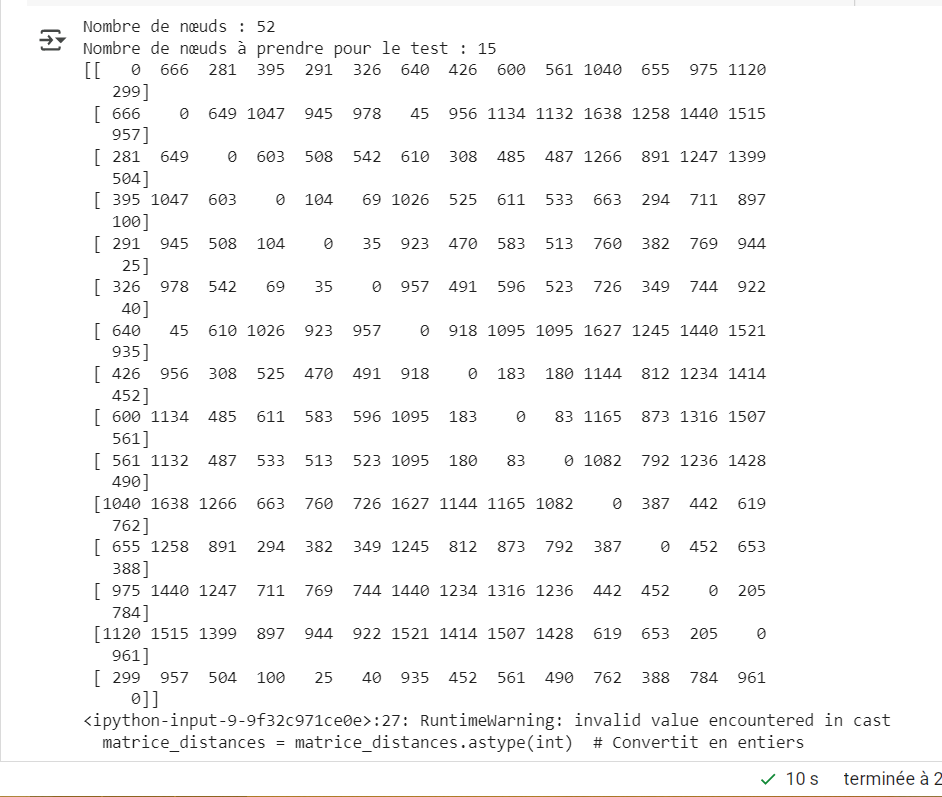

### **Visualisation du graphe construit à partir de la matrice de distances**

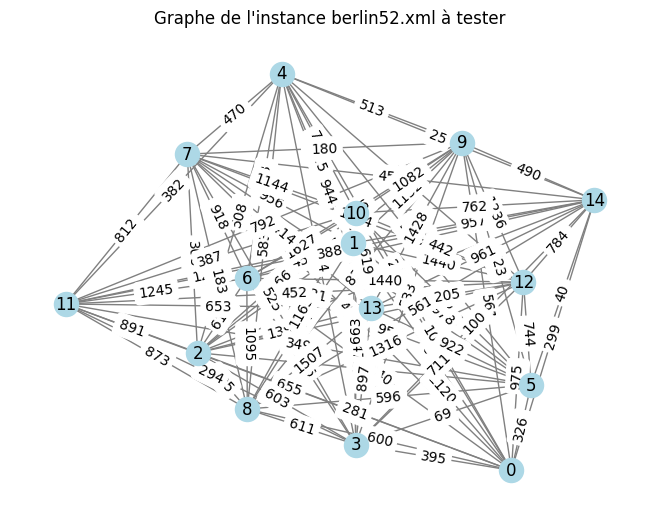

In [ ]:
import networkx as nx

# Créer un graphe à partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance " +instance+ " à tester")
plt.show()

## **L'exécution principale — Lancement et test de l'algorithme**

Cette cellule sert de point d’entrée pour tester l’implémentation de l’algorithme du voyageur de commerce sur une instance jouet (8 villes). Elle permet de :

* Valider le fonctionnement de l’algorithme (résultat correct, coût minimal cohérent)
* Mesurer la performance temporelle de l’approche dynamique implémentée
* Fournir une base de test simple avant de passer à des instances plus grandes ou réelles (comme celles de TSPLIB)

In [ ]:
if __name__ == '__main__':
    matrice_distances = [
    [0, 10, 15, 20, 0, 10, 15, 20],
    [10, 0, 35, 25, 10, 0, 35, 25],
    [15, 35, 0, 30, 15, 35, 0, 30],
    [20, 25, 30, 0, 20, 25, 30, 0],
    [0, 10, 15, 20, 0, 10, 15, 20],
    [10, 0, 35, 25, 10, 0, 35, 25],
    [15, 35, 0, 30, 15, 35, 0, 30],
    [20, 25, 30, 0, 20, 25, 30, 0]
]
#Choix de la ville de départ pour le parcours (indice 0 ici)
    start_city = 0
    start_time = time.time()
#Création d’une instance du problème et lancement de la résolution par programmation dynamique
    tour = TravellingSalesmanProblem(matrice_distances , start_city)
    tour.solve()
    end_time = time.time()
    temps_execution = end_time - start_time
    print("Shortest path :", tour.shortest_path)
    print("Minimum path cost :", tour.min_path_cost)
    print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Shortest path : [0, 4, 1, 5, 2, 3, 6, 7]
Minimum path cost : 80
Temps d'exécution : 0.002000 secondes


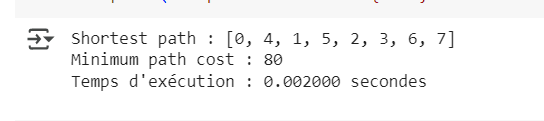

In [ ]:
start_city = 0
start_time = time.time()
#Instanciation de la classe TSP avec la sous-matrice extraite
tour = TravellingSalesmanProblem(sous_ensemble_matrice_liste, start_city)
tour.solve()
end_time = time.time()
temps_execution = end_time - start_time
print("Shortest path :", tour.shortest_path)
print("Minimum path cost :", tour.min_path_cost)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Shortest path : [0, 2, 7, 9, 8, 14, 4, 5, 3, 11, 6, 1, 10, 12, 13]
Minimum path cost : 4962
Temps d'exécution : 0.542992 secondes


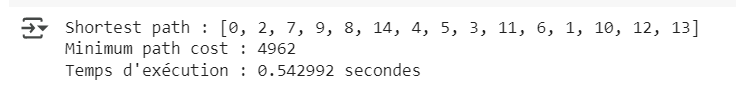